In [1]:
import json

import numpy as np
import matplotlib.pylab as plt

from lattice_translocators.generators.Translocator import Translocator

from lattice_translocators.engines.MultistateSymmetricExtruder import MultistateSymmetricExtruder

# Extrusion dictionary

In [2]:
with open("uniform_dict_multistate.json", 'r') as dict_file:
    paramdict = json.load(dict_file)


In [3]:
monomers_per_replica = paramdict['monomers_per_replica'] 
sites_per_monomer = paramdict['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer

In [4]:
# Work with a single type of monomers (A, assigned to type index 0)
type_list = ['A']

monomer_types = type_list.index('A') * np.ones(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)

In [5]:
# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict['LEF_lifetime']
CTCF_facestall = paramdict['CTCF_facestall']

print(LEF_lifetime['A'], CTCF_facestall['A'])

243.41412012644878 1.0


# Making extruders

In [6]:
# Create some CTCF boundary sites
tad_size = 20 # in monomers

ctcf_left_positions = np.arange(0, sites_per_replica, tad_size*sites_per_monomer)
ctcf_right_positions = np.arange(0, sites_per_replica, tad_size*sites_per_monomer)

In [7]:
translocator = Translocator(MultistateSymmetricExtruder,
                            type_list, 
                            site_types,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **paramdict)

# Running the simulation

## State equilibration

In [8]:
simulation_time = 3600
LEF_states = []

for _ in range(simulation_time):
    translocator.engine.step()
    LEF_states.append(translocator.engine.lef_states.copy())

In [9]:
LEF_states = np.asarray(LEF_states)
state_counts = np.zeros((len(LEF_states), 5))

for i in range(5):
    state_counts[:, i] = np.count_nonzero(LEF_states==i, axis=1)

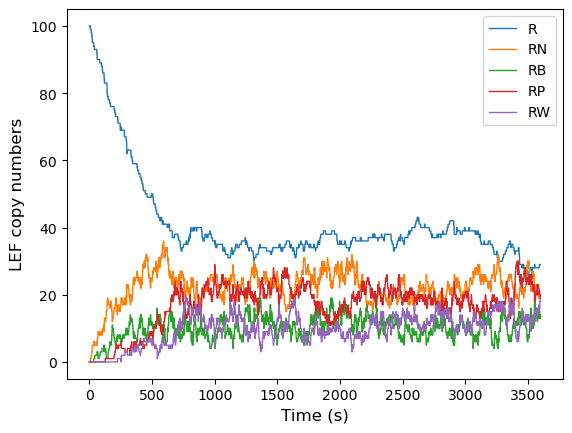

In [10]:
state_list = ['R'] + list(paramdict['LEF_states'].keys())

plt.plot(state_counts, lw=1)
plt.legend(state_list, loc='best')
          
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('LEF copy numbers', fontsize=12)

plt.show()

## Production run

In [11]:
translocator.run(period=1)

In [12]:
def rle(state_bool_array):
    if len(state_bool_array) > 0:
        transitions = np.diff(state_bool_array)

        starts = np.r_[0, np.flatnonzero(transitions)]
        lengths = np.diff(np.r_[starts, len(state_bool_array)])

        return starts, lengths

    else:
        return [], []

In [13]:
LEF_states = np.asarray(translocator.state_trajectory)

for state_id, state in enumerate(state_list):
    lifetimes = []

    for lef in range(translocator.engine.num_LEF):
        state_bool_array = (LEF_states[:, lef] == state_id)
        starts, lengths = rle(state_bool_array)

        if state_bool_array[starts[0]]:
            binding_times = lengths[::2] if state_id > 0 else lengths[1::2]
        else:
            binding_times = lengths[1::2] if state_id > 0 else lengths[::2]

        if len(binding_times) > 0:
            lifetimes.append(binding_times.mean())

    mean_lifetime = np.mean(lifetimes) if len(lifetimes) > 0 else 0

    print("Mean %s lifetime: %.2f s" % (state[-1], mean_lifetime))

Mean R lifetime: 1301.30 s
Mean N lifetime: 79.62 s
Mean B lifetime: 33.20 s
Mean P lifetime: 69.98 s
Mean W lifetime: 44.90 s


In [14]:
hist = []
frac_active_LEFs = np.zeros(paramdict['steps'])

for i, lef_pos in enumerate(translocator.lef_trajectory):
    lef_state = translocator.state_trajectory[i]
    frac_active_LEFs[i] = np.count_nonzero(lef_state == paramdict['LEF_states']['RN']) / float(translocator.engine.num_LEF)

    hist.extend(lef_pos)

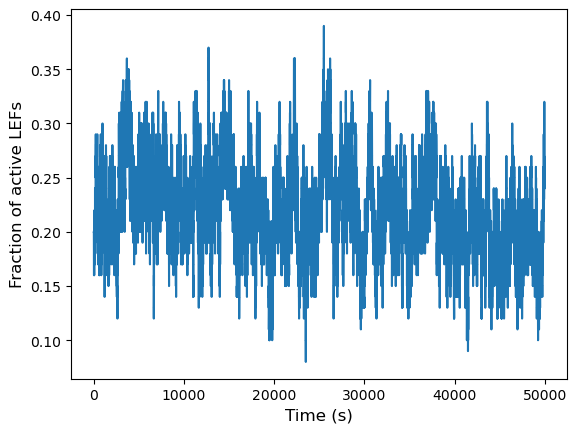

In [15]:
plt.plot(frac_active_LEFs)
          
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Fraction of active LEFs', fontsize=12)

plt.show()

# Kymograph Analysis

In [16]:
def map_from_lefs(dset, sites_per_replica):
    
    ll = np.mod(dset, sites_per_replica)
    ll = ll[ll[:,1] > ll[:,0]]
    
    lmap = np.histogram2d(ll[:,0], ll[:,1], np.arange(sites_per_replica))[0]
    
    return (lmap + lmap.T)

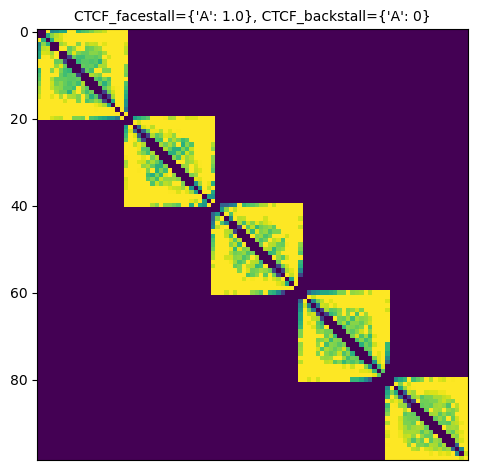

In [17]:
kymograph = map_from_lefs(hist, sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict['sites_per_monomer'])), fignum=False) 
            
plt.title('CTCF_facestall=%s, CTCF_backstall=%s' % (paramdict['CTCF_facestall'],
                                                    paramdict['CTCF_backstall']),
          fontsize=10)

plt.xticks([])
plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.show()                       
